# Collaborative Filtering recommender model using full 32M Movieslens Dataset
- Using Tensorflow
- Model is then saved in ONNX format

In [1]:
import pandas as pd
import os
from pathlib import Path

# TensorFlow
from tf_keras.models import Model, load_model
from tf_keras.layers import Input, Embedding, Dot, Reshape, Dropout
from tf_keras.optimizers import Adam
from tf_keras.optimizers.legacy import Adam  # For mac M1/M2
from tf_keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
from platform import python_version
print(python_version())

3.11.12


In [3]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [4]:
BASEDIR = ".."
MODEL_DIR      = os.path.join(BASEDIR, "saved_models")
model_filename = os.path.join(MODEL_DIR, "collaboration_filter.01.keras")

# Create Model directory
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

In [5]:
movielens_dataset = "full" # "full" #"small"

## Step 1.1: Load the Dataset (ratings.csv)
The full dataset has more than 32 million ratings

In [6]:
print("Loading ratings.csv...")
try:
    df_ratings = pd.read_csv(f'../../movielens_data/{movielens_dataset}/ratings.csv')
    print(f"Loaded {len(df_ratings)} ratings.")
except FileNotFoundError:
    print("Error: ratings.csv not found. Please place it in the same directory.")
    exit()

Loading ratings.csv...
Loaded 32000204 ratings.


## Step 1.2: Create Mappings for User and Movie IDs 
We need to convert the arbitrary user and movie IDs into a continuous 0-based index.

In [7]:
# Get all unique user and movie IDs
unique_user_ids = df_ratings['userId'].unique()
unique_movie_ids = df_ratings['movieId'].unique()

# Create a mapping from userId to a new 0-based index (user_idx)
user_map = {id: i for i, id in enumerate(unique_user_ids)}
# Create a mapping from movieId to a new 0-based index (movie_idx)
movie_map = {id: i for i, id in enumerate(unique_movie_ids)}

print("\nCreated user and movie ID mappings.")
# Example: See what the first few user IDs map to
print("User map sample:", {k: user_map[k] for k in list(user_map)[:5]})
# Example: See what the first few movies IDs map to
print("Movie map sample:", {k: movie_map[k] for k in list(movie_map)[:5]})


Created user and movie ID mappings.
User map sample: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Movie map sample: {17: 0, 25: 1, 29: 2, 30: 3, 32: 4}


## Step 1.3: Apply Mappings to the DataFrame

In [8]:
# Create new columns in the DataFrame that contain the 0-based indices.
df_ratings['user_idx'] = df_ratings['userId'].map(user_map)
df_ratings['movie_idx'] = df_ratings['movieId'].map(movie_map)

print("Applied mappings to create new 'user_idx' and 'movie_idx' columns.")
print("\nDataFrame head with new index columns:")
print(df_ratings.head())

Applied mappings to create new 'user_idx' and 'movie_idx' columns.

DataFrame head with new index columns:
   userId  movieId  rating  timestamp  user_idx  movie_idx
0       1       17     4.0  944249077         0          0
1       1       25     1.0  944250228         0          1
2       1       29     2.0  943230976         0          2
3       1       30     5.0  944249077         0          3
4       1       32     5.0  943228858         0          4


## Step 1.4: Prepare the Final Data for TensorFlow
We now have everything we need to create our input and output arrays for the model.

In [9]:
# Get the total number of unique users and movies. This is our "vocabulary size".
num_users = len(user_map)
num_movies = len(movie_map)
print(f"\nTotal unique users: {num_users}")
print(f"Total unique movies: {num_movies}")

# Prepare the input 'x' (a list of two arrays: user indices and movie indices)
x = [df_ratings['user_idx'].values, df_ratings['movie_idx'].values]

# Prepare the output 'y' (the ratings)
y = df_ratings['rating'].values

print("\nData is now prepared for TensorFlow model training.")
print(f"Shape of x[0] (user_idx): {x[0].shape}")
print(f"Shape of x[1] (movie_idx): {x[1].shape}")
print(f"Shape of y (ratings): {y.shape}")


Total unique users: 200948
Total unique movies: 84432

Data is now prepared for TensorFlow model training.
Shape of x[0] (user_idx): (32000204,)
Shape of x[1] (movie_idx): (32000204,)
Shape of y (ratings): (32000204,)


## Step 2.1: Define Model Hyper-parameters

In [10]:
# Let's define the size of our embedding vectors.
# This is a key parameter to tune. It also directly impact the size of the model
EMBEDDING_DIM = 64

DROPOUT = 0.15

LEARNING_RATE = 0.0014

BATCH_SIZE = 16384

EPOCH = 60

## Step 2.2: Define the Model Architecture using Keras Functional API

In [11]:
# Define the input layers for user and movie indices
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# --- User Pathway ---
# 1. User Embedding Layer: Turns the user index into a dense vector
user_embedding = Embedding(input_dim=num_users,
                           output_dim=EMBEDDING_DIM,
                           name='user_embedding')(user_input)
# 2. Reshape the embedding to remove the extra dimension
user_vector = Reshape((EMBEDDING_DIM,), name='user_vector')(user_embedding)
user_vector = Dropout(DROPOUT, name='user_dropout')(user_vector)

# --- Movie Pathway ---
# 1. Movie Embedding Layer: Turns the movie index into a dense vector
movie_embedding = Embedding(input_dim=num_movies,
                            output_dim=EMBEDDING_DIM,
                            name='movie_embedding')(movie_input)
# 2. Reshape the embedding to remove the extra dimension
movie_vector = Reshape((EMBEDDING_DIM,), name='movie_vector')(movie_embedding)
movie_vector = Dropout(DROPOUT, name='movie_dropout')(movie_vector)


# --- Combine the pathways ---
# Use a Dot product to calculate the core interaction between user and movie vectors
dot_product = Dot(axes=1, name='dot_product')([user_vector, movie_vector])


# --- Create and Compile the Model ---
# The model takes the user and movie inputs and outputs the dot product result
model = Model(inputs=[user_input, movie_input], outputs=dot_product)

2025-07-01 17:41:57.829381: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-07-01 17:41:57.829410: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-07-01 17:41:57.829415: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-07-01 17:41:57.829432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-01 17:41:57.829441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# Compile the model with an optimizer and a loss function
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mean_squared_error')

## Step 2.3: Display the Model Summary
This gives a nice overview of the model architecture and number of parameters.

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 64)                1286067   ['user_input[0][0]']          
                                                          2                                       
                                                                                                  
 movie_embedding (Embedding  (None, 1, 64)                5403648   ['movie_input[0][0]']     

### Note on Model size
**18 millions parameters** is small compared to a llama 70 billions parameters.
But it is very big compared to the 4 models I used in my app [Mix on Pix](https://apps.apple.com/us/app/mix-on-pix-text-on-photos/id633281586). 
They had 0.5 millions parameters each (but they run locally on an iPhone).

In [14]:
# when running for many epochs, the reduction must be very slow.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.70,
                                            mode='min',
                                            min_delta=0.000001,
                                            min_lr=0.0000001)

In [15]:
# Save the Best model
checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1, save_best_only=True)

callbacks_list = [checkpoint, learning_rate_reduction]

## Step 3.1: Create Training and Validation Sets

In [16]:
# We use scikit-learn's train_test_split to randomly shuffle and split our data.
# We'll use 90% for training and 10% for validation.
(train_users, val_users,
 train_movies, val_movies,
 train_ratings, val_ratings) = train_test_split(x[0], x[1], y, test_size=0.1, random_state=42)

print("Data split into training and validation sets:")
print(f"Training samples: {len(train_users)}")
print(f"Validation samples: {len(val_users)}")

Data split into training and validation sets:
Training samples: 28800183
Validation samples: 3200021


## Step 3.2: Train the Model

In [17]:
# Now we call model.fit() to start the training process.
print("\nStarting model training...")
history = model.fit(
    # Input data for training
    x=[train_users, train_movies],
    # Target data for training
    y=train_ratings,
    # Number of samples per gradient update
    batch_size=BATCH_SIZE,  
    # Number of times to iterate over the entire training dataset
    epochs=EPOCH,
    # Display training progress
    verbose=1,
    # Data to evaluate the model on at the end of each epoch
    validation_data=([val_users, val_movies], val_ratings),
    callbacks=callbacks_list
)
print("Model training complete.")


Starting model training...
Epoch 1/60


2025-07-01 17:42:06.308948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1758/1758 [==============================] - ETA: 0s - loss: 3.3391
Epoch 1: val_loss improved from inf to 0.81515, saving model to ../saved_models/collaboration_filter.01.keras
1758/1758 [==============================] - 48s 23ms/step - loss: 3.3391 - val_loss: 0.8151 - lr: 0.0014
Epoch 2/60
1758/1758 [==============================] - ETA: 0s - loss: 0.8531
Epoch 2: val_loss improved from 0.81515 to 0.72816, saving model to ../saved_models/collaboration_filter.01.keras
1758/1758 [==============================] - 36s 21ms/step - loss: 0.8531 - val_loss: 0.7282 - lr: 0.0014
Epoch 3/60
1758/1758 [==============================] - ETA: 0s - loss: 0.7969
Epoch 3: val_loss improved from 0.72816 to 0.69338, saving model to ../saved_models/collaboration_filter.01.keras
1758/1758 [==============================] - 36s 20ms/step - loss: 0.7969 - val_loss: 0.6934 - lr: 0.0014
Epoch 4/60
1758/1758 [==============================] - ETA: 0s - loss: 0.7659
Epoch 4: val_loss improved from 0.69338

## Step 3.3: Visualize Training History

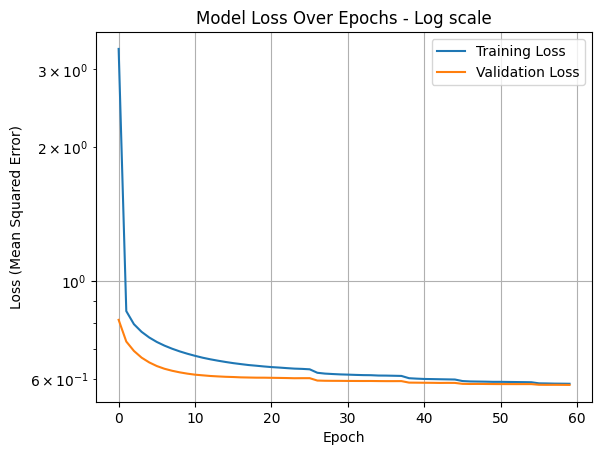

In [18]:
# The 'history' object contains the loss values from training.
# We can plot them to see how the model learned over time.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs - Log scale')
plt.ylabel('Loss (Mean Squared Error)')
plt.yscale("log")
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Delete the existing model
del model

# Load last saved model
model = load_model(model_filename)

In [20]:
# 'model' is our trained Keras model
# We get the layer by its name, then get its learned weights.
# get_weights() returns a list, the first item is the embedding matrix.
movie_embedding_matrix = model.get_layer('movie_embedding').get_weights()[0]

print(f"Shape of our learned movie embedding matrix: {movie_embedding_matrix.shape}")

Shape of our learned movie embedding matrix: (84432, 64)


In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# We need the mappings from our data prep step to go from title -> ID -> index
# user_map, movie_map
# We also need a reverse mapping from index back to title
# Let's create a DataFrame with movie titles and their learned indices
df_movies = pd.read_csv(f'../../movielens_data/{movielens_dataset}/movies.csv')
df_movies['movie_idx'] = df_movies['movieId'].map(movie_map)
# Drop movies that were not in our ratings dataset
df_movies = df_movies.dropna(subset=['movie_idx'])
df_movies['movie_idx'] = df_movies['movie_idx'].astype(int)

# Create the reverse map from index to title
idx_to_title = df_movies.set_index('movie_idx')['title'].to_dict()

In [22]:
def find_similar_movies(movie_title, top_n=10):
    """
    Finds movies similar to a given movie using the learned embeddings.
    """
    try:
        # 1. Get the movie_idx for the given title
        movie_idx = df_movies[df_movies['title'] == movie_title]['movie_idx'].iloc[0]

        # 2. Get the embedding vector for that movie
        movie_vector = movie_embedding_matrix[movie_idx]

        # 3. Calculate cosine similarity between that vector and all others
        # We reshape our vector to (1, EMBEDDING_DIM) to make it a 2D array
        sim_scores = cosine_similarity(movie_vector.reshape(1, -1), movie_embedding_matrix)

        # 4. Get the similarity scores for all movies and sort them
        # sim_scores is a 2D array, so we take the first row
        sim_scores = list(enumerate(sim_scores[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # 5. Get the top N results, excluding the movie itself
        top_similar_movies = [
            (idx_to_title.get(i, "Unknown"), score)
            for i, score in sim_scores[1:top_n + 1]
        ]

        print(f"Top {top_n} movies similar to '{movie_title}':")
        for title, score in top_similar_movies:
            print(f"  - {title} (Similarity: {score:.4f})")

    except IndexError:
        print(f"Movie '{movie_title}' not found in the dataset.")

In [23]:
# --- Let's test it! ---
find_similar_movies('Apocalypse Now (1979)')
print("-" * 30)
find_similar_movies('Arrival (2016)')
print("-" * 30)
find_similar_movies('Inception (2010)')
print("-" * 30)
find_similar_movies('My Life as a Dog (Mitt liv som hund) (1985)')
print("-" * 30)
find_similar_movies('Other Guys, The (2010)')
print("-" * 30)

Top 10 movies similar to 'Apocalypse Now (1979)':
  - Taxi Driver (1976) (Similarity: 0.9375)
  - Full Metal Jacket (1987) (Similarity: 0.9316)
  - Deer Hunter, The (1978) (Similarity: 0.9226)
  - Raging Bull (1980) (Similarity: 0.9062)
  - Chinatown (1974) (Similarity: 0.9013)
  - Platoon (1986) (Similarity: 0.8915)
  - Mariupolis (2016) (Similarity: 0.8914)
  - Modus Operandi (2010) (Similarity: 0.8877)
  - My Best Friend's Famous (2019) (Similarity: 0.8849)
  - No Country for Old Men (2007) (Similarity: 0.8763)
------------------------------
Top 10 movies similar to 'Arrival (2016)':
  - Ex Machina (2015) (Similarity: 0.9000)
  - Moon (2009) (Similarity: 0.8620)
  - LIFE BEYOND: Chapter 2. The Museum of Alien Life (2020) (Similarity: 0.8548)
  - Pornography: A Secret History of Civilisation (1999) (Similarity: 0.8531)
  - Coherence (2013) (Similarity: 0.8520)
  - The Martian (2015) (Similarity: 0.8514)
  - Annihilation (2018) (Similarity: 0.8511)
  - Crimes Against Humanity (2017) (

In [24]:
# --- More tests ---
find_similar_movies('Toy Story (1995)')
print("-" * 30)
find_similar_movies('Parenthood (1989)')
print("-" * 30)
find_similar_movies('Eyes Wide Shut (1999)')
print("-" * 30)
find_similar_movies('Thirteenth Floor, The (1999)')
print("-" * 30)
find_similar_movies('Little Miss Sunshine (2006)')
print("-" * 30)
find_similar_movies('Finding Nemo (2003)')
print("-" * 30)
find_similar_movies('Wild (2016)')
print("-" * 30)
find_similar_movies('Hidden Figures (2016)')
print("-" * 30)
find_similar_movies('Before Midnight (2013)')
print("-" * 30)
find_similar_movies('Begin Again (2013)')
print("-" * 30)

Top 10 movies similar to 'Toy Story (1995)':
  - Toy Story 2 (1999) (Similarity: 0.9840)
  - Toy Story 3 (2010) (Similarity: 0.9478)
  - Monsters, Inc. (2001) (Similarity: 0.9352)
  - Finding Nemo (2003) (Similarity: 0.9252)
  - Bug's Life, A (1998) (Similarity: 0.9225)
  - Incredibles, The (2004) (Similarity: 0.9064)
  - Iron Giant, The (1999) (Similarity: 0.8575)
  - Up (2009) (Similarity: 0.8526)
  - Toy Story 4 (2019) (Similarity: 0.8508)
  - Wreck-It Ralph (2012) (Similarity: 0.8503)
------------------------------
Top 10 movies similar to 'Parenthood (1989)':
  - Mr. Mom (1983) (Similarity: 0.8905)
  - Stand by Me (1986) (Similarity: 0.8730)
  - Big (1988) (Similarity: 0.8717)
  - Midnight Run (1988) (Similarity: 0.8703)
  - No Way Out (1987) (Similarity: 0.8668)
  - Biloxi Blues (1988) (Similarity: 0.8623)
  - Moonlight Sonata: Deafness in Three Movements (2019) (Similarity: 0.8612)
  - Trading Places (1983) (Similarity: 0.8582)
  - Lady Beware (1987) (Similarity: 0.8572)
  - Hom

## Step 4 - Create an ONNX model

In [25]:
import tf2onnx
import onnx

In [26]:
ONNX_OUTPUT_FILE = os.path.join(MODEL_DIR, "cf_recommender.onnx")

## Step 4.1: Define the Input Signature for our Multi-Input Model

In [27]:
print("Defining the input signature for ONNX conversion...")

# Our model has two inputs (the user and the movie), so our signature will be a tuple of two TensorSpecs.
# The `name` in each TensorSpec MUST match the name of the Input layer in your Keras model.
# The shape [None, 1] means the model can accept batches of any size (None), where each input is a single value (1).
input_signature = (
    tf.TensorSpec([None, 1], tf.int32, name='user_input'),
    tf.TensorSpec([None, 1], tf.int32, name='movie_input')
)

print("Input signature defined:")
print(f"  - Input 1: name='{input_signature[0].name}', shape={input_signature[0].shape}, dtype={input_signature[0].dtype.name}")
print(f"  - Input 2: name='{input_signature[1].name}', shape={input_signature[1].shape}, dtype={input_signature[1].dtype.name}")

Defining the input signature for ONNX conversion...
Input signature defined:
  - Input 1: name='user_input', shape=(None, 1), dtype=int32
  - Input 2: name='movie_input', shape=(None, 1), dtype=int32


## Step 4.2: Convert the Model to ONNX Format

In [29]:
# The opset version is important. 13 or 15 are good, stable choices.
print(f"\nConverting model to ONNX with opset 15...")

onnx_model, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=input_signature,
    opset=15
)


Converting model to ONNX with opset 15...


2025-07-01 18:58:29.332728: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-07-01 18:58:29.333445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-01 18:58:29.333453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-07-01 18:58:29.681108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-01 18:58:29.681133: I tensorflow/core/com

In [30]:
# Save the ONNX model to a file
onnx.save(onnx_model, ONNX_OUTPUT_FILE)

print(f"SUCCESS: Model successfully converted and saved to:")
print(f"  {ONNX_OUTPUT_FILE}")

SUCCESS: Model successfully converted and saved to:
  ../saved_models/cf_recommender.onnx
